# Machine Learning 2 - Semester Project
# Garbage Classification

<div class="alert alert-block alert-info">
<b>Tip:</b> Revised Order:

1. **Data Collection:**
   - Collect a dataset of images representing different types of garbage items (plastic, paper, glass, etc.).
   - Found multiple data sets on kaggle
    
2. **Image Classification:**
   - Use convolutional neural networks (CNNs) to build an image classification model.
   - Train the model to recognize and classify each type of garbage item.
   - Evaluate the model's performance using appropriate metrics.

3. **Pre-trained Models Comparison:**
   - Choose popular pre-trained models for image classification (e.g., ResNet, VGG, MobileNet).
   - Fine-tune these models on your garbage classification dataset.
   - Evaluate the performance of the fine-tuned models.
   - Compare the performance metrics with your custom-trained model.

4. **Clustering and Dimension Reduction:**
   - Apply clustering algorithms (e.g., K-Means) to group similar garbage items together.
        - (Hope to find clusters like: recycleable/ bio/ others
   - Use dimension reduction techniques (e.g., PCA) to visualize and analyze the features of the garbage items.

5. **Integrating Recommendations:**
   - Implement a recommendation system that suggests the appropriate recycling bin for a given item.
        - maybe simple tree??
   - Use knowledge from the clustering and dimension reduction to enhance recommendation accuracy.


</div>

<div class="alert alert-block alert-info">
<b>Training Metrics Explanation:</b>

- **loss:**
  - The training loss at the end of the epoch. It represents the average value of the loss function across all training samples.

- **accuracy:**
  - The training accuracy at the end of the epoch. It represents the proportion of correctly classified training samples.

- **val_loss:**
  - The validation loss at the end of the epoch. It represents the average value of the loss function across all validation samples.
  
  Categorical Crossentropy Loss Formula:
  
  
  Categorical Crossentropy Loss =$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \cdot \log(\hat{y}_{i,j})$

  Where:
    - $N$ is the number of samples in the batch.
    - $C$ is the number of classes.
    - $y_{i,j}$ is 1 if the true class of sample \(i\) is \(j\), 0 otherwise.
    - $(\hat{y}_{i,j})$ is the predicted probability that sample \(i\) belongs to class \(j\).

- **val_accuracy:**
  - The validation accuracy at the end of the epoch. It represents the proportion of correctly classified validation samples.
</div>


In [24]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install ann_visualizer
# Libraries for Images
import os
import glob
from PIL import Image

# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#!pip install keras-tuner
#import keras_turner
from keras_tuner.tuners import BayesianOptimization

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


#ResNET
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Statistical Test
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model


#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor


from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model



#Own functions
import sys
from Own_Functions.k_fold_utils import k_fold_cross_validation
from Own_Functions.compare_models import compare_models
from Own_Functions.compare_model_performance import compare_model_performance
from Own_Functions.check_compile import check_compile
from Own_Functions.count_images_in_subfolders import count_images_in_subfolders
from Own_Functions.evaluate_model import evaluate_model
from Own_Functions.save_results_to_json import save_results_to_json
from Own_Functions.save_history_to_json import save_history_to_json
from Own_Functions.subgenerator_utils import create_subgenerator 
from Own_Functions.plot_metric_across_folds import plot_metric_across_folds 
from Own_Functions.plot_comparison_across_folds import plot_comparison_across_folds 

## Download Data for Images 

In [25]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [4]:
image_overview['Number_Images'].sum()

15515

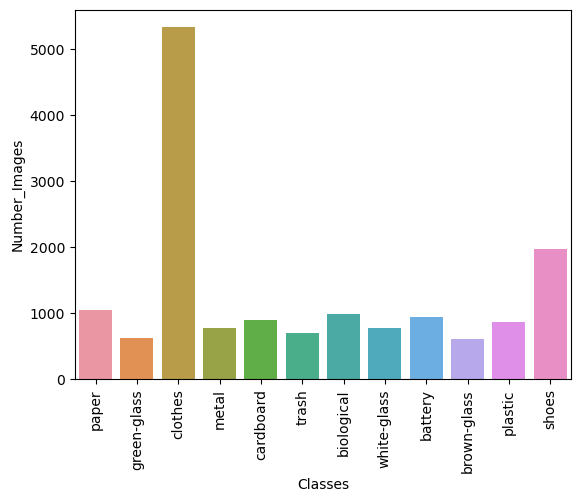

In [5]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

### Use ImageData Generator 

In [6]:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Define the ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2,  # Split data into training and validation sets
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Define the target image size
target_size = (256,256)  # Adjust according to your model's input size

# Create the training data generator
train_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,         # Adjust based on your system's memory
    class_mode='categorical',  # Assumes a classification task
    subset='training'      # Specify 'training' for training data
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'    # Specify 'validation' for validation data
)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [18]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pfad zum Hauptverzeichnis der Daten
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Liste zum Speichern der Dateipfade und Labels
file_paths = []
labels = []

# Angenommen, jedes Unterverzeichnis im Root-Verzeichnis entspricht einer Klasse
for class_name in os.listdir(root_folder_path):
    class_dir = os.path.join(root_folder_path, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_name, file_name))  # Speichere relativen Pfad
            labels.append(class_name)

# Konvertiere Listen in Arrays für die Verarbeitung
file_paths = np.array(file_paths)
labels = np.array(labels)

# Aufteilung der Daten in Training+Validierung und Test, stratifizierte Aufteilung
file_paths_train_val, file_paths_test, labels_train_val, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Aufteilung der Trainings- und Validierungsdaten, stratifizierte Aufteilung
file_paths_train, file_paths_val, labels_train, labels_val = train_test_split(
    file_paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)


# Initialisiere ImageDataGenerator-Instanzen für Training und Validierung/Test ohne Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Da wir die Dateipfade und Labels direkt haben, könnten wir hier flow_from_dataframe oder eine ähnliche Methode benötigen
# Dies erfordert, dass du ein DataFrame aus den Pfaden und Labels erstellst

# Erstelle DataFrames
df_train = pd.DataFrame({'filepath': file_paths_train, 'label': labels_train})
df_val = pd.DataFrame({'filepath': file_paths_val, 'label': labels_val})
df_test = pd.DataFrame({'filepath': file_paths_test, 'label': labels_test})

# Initialisiere ImageDataGenerator für Training mit Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Für Validierung und Test ohne Augmentierung, nur Reskalierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Erstelle den Trainingsdatengenerator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstelle den Validierungsdatengenerator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstelle den Testdatengenerator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Wichtig für die Bewertung, um die Reihenfolge beizubehalten
)


Found 9309 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


In [8]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [8]:
# Get a batch from the training generator
#batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
#num_images_to_visualize = 12
#for i in range(num_images_to_visualize):
    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Label: {label_index}")
#    plt.show()

In [9]:
# Get a batch from the training generator
#batch_images, batch_labels = next(validation_generator)

# Visualize the first few images in the batch
#num_images_to_visualize = 5
#for i in range(num_images_to_visualize):
#    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
#    
#    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Label: {label_index}")
#    plt.show()

In [10]:
# Visualize the first few images in the batch with class names
#for i in range(num_images_to_visualize):
#    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
#    class_name = class_names[label_index]
#    
#    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Class Name: {class_name}")
#    plt.show()


***
## Definition of Test Statistics

*** 
## Definition K-Fold Cross Validation Function

***
### Visualisierungen Cross Validation

***
## Implementing CNN - own build

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Klassen und ihre Frequenz
y_integers = np.array(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Umwandlung von Klassenindizes in ein Dictionary mit Klassennamen als Schlüssel
class_indices = train_generator.class_indices  # Sollte ein Dictionary sein: {'class1': 0, 'class2': 1, ...}
class_weights_dict
# Erstellen eines neuen Dictionaries, das Klassennamen den Gewichten zuordnet
class_weights_by_name = {class_name: class_weights_dict[class_index] for class_name, class_index in class_indices.items()}
class_weights_by_name

{'battery': 1.3681657848324515,
 'biological': 1.3126057529610828,
 'brown-glass': 2.131181318681319,
 'cardboard': 1.45,
 'clothes': 0.24280125195618155,
 'green-glass': 2.0576923076923075,
 'metal': 1.6827548806941433,
 'paper': 1.2313492063492064,
 'plastic': 1.4947013487475915,
 'shoes': 0.6540893760539629,
 'trash': 1.8514319809069213,
 'white-glass': 1.668279569892473}

In [10]:
from sklearn.utils import class_weight

num_classes = len(train_generator.class_indices)

## CNN2 - max pooling, relu, batch normalization, dropout, 

In [19]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn2.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn2 = load_model(checkpoint_path)
    print("Modell erfolgreich geladen.")
else:
    # Define the model
    model_cnn2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model_cnn2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn2.summary()

    #checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
    #checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
    
    # Define a callback to save the best model during training
    #checkpoint = ModelCheckpoint(os.path.join(model_path, 'best_model_cnn2.keras'), monitor='val_loss', save_best_only=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    # Train the model
    history_cnn2 = model_cnn2.fit(
        train_generator,
        epochs=2,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

Modell erfolgreich geladen.


In [ ]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/' 
history_filename_cnn2_training_history = 'best_model_cnn2_training_history.json'

# Speichern der Historie
save_history_to_json(history_cnn2, history_filename_cnn2_training_history, history_path)


In [13]:
check_compile(model_cnn2)

NameError: name 'check_compile' is not defined

In [31]:
with open(os.path.join(model_path, history_filename_cnn2_training_history), 'r') as file:
    loaded_history = json.load(file)   

***
### Evalutation Protocoll: K-Fold Cross Validation for CNN2

In [22]:
fold_performance_model_cnn2, avg_perf_model_cnn2, fold_histories_model_cnn2 = k_fold_cross_validation(model_cnn2, 
                                                                                                      train_generator, 
                                                                                                      n_splits=5, 
                                                                                                      epochs=20)

#fange mit 20 Epochen an und gehe dann hoch auf +50

Found 4654 validated image filenames belonging to 12 classes.
Found 4655 validated image filenames belonging to 12 classes.
145/145 [==============================] - 220s 2s/step - loss: 2.0923 - accuracy: 0.4414 - val_loss: 2.9120 - val_accuracy: 0.3136
Found 4655 validated image filenames belonging to 12 classes.
Found 4654 validated image filenames belonging to 12 classes.
145/145 [==============================] - 234s 2s/step - loss: 2.1131 - accuracy: 0.4311 - val_loss: 2.8608 - val_accuracy: 0.2463


In [45]:
# Convert NumPy arrays in histories to lists
fold_histories_lists_model2 = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_model_cnn2  # use the correct variable here
]

results = {
    "fold_performance": fold_performance_model_cnn2,
    "average_performance": avg_perf_model_cnn2,
    "fold_histories": fold_histories_lists_model2
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_model_cnn2_cvr.json', results)

Ergebnisse wurden in 'fold_performance_model_cnn2_cvr.json' gespeichert.


In [46]:
#file_name = 'fold_performance_model_cnn2_cvr.json'
#full_path = os.path.join(default_path, file_name)

#with open(full_path, 'r') as file:
#    results = json.load(file)

# Extract the histories
#fold_histories = results['fold_histories']

## CNN3 - max pooling, stride 1,2 , padding = valid, relu

In [61]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn3.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn3 = load_model(checkpoint_path)
else:
    model_cnn3 = tf.keras.models.Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = num_classes, activation='softmax')  # Adjust 'num_classes' based on your task
])

    # Compile the model
    model_cnn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn3.summary()

    #checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
    #checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
    
    # Define a callback to save the best model during training
    #checkpoint = ModelCheckpoint(os.path.join(model_path, 'best_model_cnn2.keras'), monitor='val_loss', save_best_only=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    # Train the model
    history_cnn3 = model_cnn3.fit(
        train_generator,
        epochs=50,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)       

In [62]:
check_compile(model_cnn3)

Alright. Model is already compiled and trained


In [63]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_cnn3 = 'best_model_cnn3_training_history.json'

# Speichern der Historie
save_history_to_json(history_cnn3, history_filename_cnn3, history_path)

In [64]:
# Speichern der Daten in einer JSON-Datei
with open(os.path.join(model_path, history_filename_cnn3), 'r') as file:
    loaded_history = json.load(file)

***
### Evalutation Protocoll: K-Fold Cross Validation for CNN3

In [66]:
fold_performance_model_cnn3, avg_perf_model_cnn3, fold_histories_model_cnn3 = k_fold_cross_validation(model_cnn3, 
                                                                                                      train_generator, 
                                                                                                      n_splits=5, 
                                                                                                      epochs=20)


Found 9932 validated image filenames belonging to 12 classes.
Found 2483 validated image filenames belonging to 12 classes.
Epoch 1/20
310/310 [==============================] - 214s 689ms/step - loss: 2.3621 - accuracy: 0.3279 - val_loss: 2.1772 - val_accuracy: 0.3657
Epoch 2/20
310/310 [==============================] - 201s 648ms/step - loss: 2.1826 - accuracy: 0.3604 - val_loss: 2.0193 - val_accuracy: 0.3795
Epoch 3/20
310/310 [==============================] - 213s 686ms/step - loss: 2.0868 - accuracy: 0.3736 - val_loss: 1.9988 - val_accuracy: 0.3799
Epoch 4/20
310/310 [==============================] - 210s 679ms/step - loss: 1.9856 - accuracy: 0.3819 - val_loss: 1.8869 - val_accuracy: 0.3900
Epoch 5/20
310/310 [==============================] - 641s 2s/step - loss: 1.8507 - accuracy: 0.3908 - val_loss: 1.5879 - val_accuracy: 0.4748
Epoch 6/20
310/310 [==============================] - 3767s 12s/step - loss: 1.6111 - accuracy: 0.4634 - val_loss: 1.9902 - val_accuracy: 0.3304
Epoc

In [67]:
# Convert NumPy arrays in histories to lists
fold_histories_lists_model3 = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_model_cnn3  # use the correct variable here
]

results_cnn3 = {
    "fold_performance": fold_performance_model_cnn3,
    "average_performance": avg_perf_model_cnn3,
    "fold_histories": fold_histories_lists_model3
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_model_cnn3_cvr.json', results)

Ergebnisse wurden in 'fold_performance_model_cnn3_cvr.json' gespeichert.


In [68]:
#file_name = 'fold_performance_model_cnn3_cvr.json'
#full_path = os.path.join(default_path, file_name)

#with open(full_path, 'r') as file:
#    results_cnn3 = json.load(file)

# Extract the histories
#fold_histories = results_cnn3['fold_histories']

***
## Hyperparameter Tuning Model

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from kerastuner.tuners import BayesianOptimization
import numpy as np
import os
import json

In [23]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers.legacy import Adam

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Tuning the number and size of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, 32), (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Tuning the number and size of dense layers
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(hp.Int(f'units_{i}', 128, 512, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, 0.1)))
        # Adding L1/L2 regularization
        model.add(Dense(units=hp.Int(f'units_{i}', 128, 512, 128), 
                        activation='relu', 
                        kernel_regularizer=l1_l2(l1=hp.Float('l1', 1e-5, 1e-2, sampling='LOG', default=1e-5), 
                                                 l2=hp.Float('l2', 1e-5, 1e-2, sampling='LOG', default=1e-4))))

    model.add(Dense(num_classes, activation='softmax'))

    # Tuning the learning rate
    hp_lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [24]:
# Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    num_initial_points=4,
    directory='bayesian_optimization',
    project_name='garbage_classification'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator, epochs=50, 
             validation_data=validation_generator, 
             callbacks=[early_stopping],
             workers=6,
            use_multiprocessing=False,)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# Build the model with the best hyperparameters
hyperparameter_model = build_model(best_hps)

Trial 5 Complete [04h 10m 19s]
val_accuracy: 0.7599999904632568

Best val_accuracy So Far: 0.8135483860969543
Total elapsed time: 15h 44m 36s


In [27]:
hyperparameter_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 128)     512       
 chNormalization)                                                
                                                      

In [25]:
# Trainieren und speichern des besten Modells
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_hp = 'hyperparameter_model.keras'
checkpoint_path = os.path.join(model_path, model_filename)

hyperparameter_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), 
                             loss='categorical_crossentropy', 
                             metrics=['accuracy'])

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=False)




history_hp = hyperparameter_model.fit(train_generator, 
                                   epochs=50, 
                                   validation_data=validation_generator, 
                                   callbacks=[checkpoint],
                                   class_weight=class_weights_dict)


#hyperparameter_model.save(checkpoint_path) -> bereits gespeichert


In [ ]:
# Speichern der Trainingshistorie
history_filename_hp = 'best_model_hp_model_training_history.json'
save_history_to_json(history_hp, history_filename_hp, model_path)

In [ ]:
with open(os.path.join(model_path, history_filename_hp), 'r') as file:
    loaded_history = json.load(file)

***
### Evalutation Protocoll: K-Fold Cross Validation for Hyperparameter Tuning Model

In [ ]:
fold_performance_hp_model, avg_perf_hp_model, fold_histories_hp_model = k_fold_cross_validation(hyperparameter_model, 
                                                                                                      train_generator, 
                                                                                                      n_splits=5, 
                                                                                                      epochs=20)


In [ ]:
# Convert NumPy arrays in histories to lists
fold_histories_lists_hp_model = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_hp_model  # use the correct variable here
]

results_hp = {
    "fold_performance": fold_performance_hp_model,
    "average_performance": avg_perf_hp_model,
    "fold_histories": fold_histories_hp_model
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_hp_model_cvr.json', results_hp)

***
# Fine-Tuning of Pre-Trained Models


## VGG16

In [ ]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.")

### Transfer Learning of VGG16

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model_VGG16_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_VGG16_transfer.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_VGG16_transfer.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_vgg16_tl.keras", monitor='val_loss', save_best_only=True)

# Train the model
history_VGG16_transfer = model_VGG16_transfer.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint],
    workers=6
)

In [ ]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16tl = 'VGG16_transfer_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_VGG16_transfer, history_filename_VGG16tl, history_path)

***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Transfer Learning Model

In [ ]:
fold_performance_VGG16tl_model, avg_perf_VGG16tl_model, fold_histories_VGG16tl_model = k_fold_cross_validation(model_VGG16_transfer, 
                                                                                                train_generator, 
                                                                                                n_splits=5, 
                                                                                                epochs=20)

In [ ]:
# Convert NumPy arrays in histories to lists
fold_histories_VGG16tl_model = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_VGG16tl_model  # use the correct variable here
]

results_VGG16tl = {
    "fold_performance": fold_performance_VGG16tl_model,
    "average_performance": avg_perf_VGG16tl_model,
    "fold_histories": fold_histories_VGG16tl_model
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_VGG16tl_model_cvr.json', results)

In [ ]:
#file_name = 'fold_performance_hp_model_cvr.json'
#full_path = os.path.join(default_path, file_name)

#with open(full_path, 'r') as file:
#    results = json.load(file)

# Extract the histories
#fold_histories = results['fold_histories']

### Fine Tuning of VGG16

In [ ]:
#Fine Tuning
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import tensorflow as tf


# 1. Laden des vortrainierten VGG16-Modells
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# 2. Anpassen des Models an meine Daten
vgg16_ft = models.Sequential()
vgg16_ft.add(base_model)  # Hinzufügen des vortrainierten Modells als Basis
vgg16_ft.add(layers.Flatten())

# Hinzufügen einiger Fully-Connected Schichten
vgg16_ft.add(layers.Dense(256, activation='relu'))
vgg16_ft.add(layers.Dropout(0.5))
vgg16_ft.add(layers.Dense(num_classes, activation='softmax')) 

# 3. Einfrieren aller Schichten im Basis-Modell
base_model.trainable = False

# 4. Kompilieren und Trainieren des Models
vgg16_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_vgg16_ft.keras", 
                             monitor='val_loss', 
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Trainieren des Modells mit Ihren eigenen `train_generator` und `validation_generator`
history_initial = vgg16_ft.fit(train_generator, 
                               validation_data=validation_generator, 
                               epochs=10, 
                               callbacks=[checkpoint])

# 5. Fine-Tuning einiger Schichten des Basis-Modells
# Auftauen der oberen Schichten des VGG16-Modells
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Kompilieren des Modells mit einer niedrigeren Lernrate
vgg16_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Erneutes Trainieren des Modells mit Fine-Tuning
history_fine_tuning = vgg16_ft.fit(train_generator, 
                                   validation_data=validation_generator, 
                                   epochs=50, 
                                   callbacks=[checkpoint, early_stopping],
                                   workers=6,
                                   class_weight=class_weights_dict)

# Display the model summary
vgg16_ft.summary()



In [ ]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16ft = 'VGG16_finetuning_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_fine_tuning, history_filename_VGG16ft, history_path)

***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Fine Tuning Model

In [ ]:
fold_performance_VGG16ft_model, avg_perf_VGG16ft_model, fold_histories_VGG16ft_model = k_fold_cross_validation(vgg16_ft, 
                                                                                                train_generator, 
                                                                                                n_splits=5, 
                                                                                                epochs=20)

In [ ]:
# Convert NumPy arrays in histories to lists
fold_histories_VGG16tl_model = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_VGG16ft_model  # use the correct variable here
]

results_VGG16tl = {
    "fold_performance": fold_performance_VGG16ft_model,
    "average_performance": avg_perf_VGG16ft_model,
    "fold_histories": fold_histories_VGG16ft_model
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_VGG16finet_model_cvr.json', results)

***
## RESNET 

In [ ]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_resnet.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_resnet.keras", monitor='val_loss', save_best_only=True)

# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint],
    workers=6,
    class_weight=class_weights_dict
)


In [ ]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_resnet = 'VGG16_finetuning_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_resnet, history_filename_resnet, history_path)

In [ ]:
fold_performance_resnet_model, avg_perf_resnet_model, fold_histories_resnet_model = k_fold_cross_validation(model_resnet, 
                                                                                                train_generator, 
                                                                                                n_splits=5, 
                                                                                                epochs=20)

In [ ]:
# Convert NumPy arrays in histories to lists
fold_histories_VGG16tl_model = [
    {key: np.array(val).tolist() for key, val in fold_history.items()} 
    for fold_history in fold_histories_resnet_model  # use the correct variable here
]

results_VGG16tl = {
    "fold_performance": fold_performance_resnet_model,
    "average_performance": avg_perf_resnet_model,
    "fold_histories": fold_histories_resnet_model
}

# Speichern der Ergebnisse
save_results_to_json('fold_performance_resnet_model_cvr.json', results)

***

## Hypothesis test of model comparition

In [ ]:
# Create a dictionary mapping models to their names

models = [model_cnn1, model_cnn2, model_cnn3, model_VGG16, model_resnet]

model_names = {
    model_cnn1: "model_cnn1",
    model_cnn2: "model_cnn2",
    model_cnn3: "model_cnn3",
    model_VGG16: "model_VGG16",
    model_resnet: "model_resnet"
}

In [ ]:

def compare_models(model_A, model_B, validation_generator, model_names, alpha=0.05):
    predictions_A = []
    predictions_B = []
    true_labels = []

    for i in range(len(validation_generator)):
        X, y = validation_generator[i]
        true_labels.extend(y)

        preds_A = model_A.predict(X, verbose=0)
        preds_B = model_B.predict(X, verbose=0)

        predictions_A.extend(preds_A)
        predictions_B.extend(preds_B)

    predictions_A = np.array(predictions_A)
    predictions_B = np.array(predictions_B)
    true_labels = np.array(true_labels)

    predicted_labels_A = np.argmax(predictions_A, axis=1)
    predicted_labels_B = np.argmax(predictions_B, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    accuracy_A = accuracy_score(true_labels, predicted_labels_A)
    accuracy_B = accuracy_score(true_labels, predicted_labels_B)

    t_statistic, p_value = ttest_rel(predicted_labels_A, predicted_labels_B)

    model_A_name = model_names.get(model_A, 'Unknown Model A')
    model_B_name = model_names.get(model_B, 'Unknown Model B')
    
    # Print a blank line for separation and then the comparison header
    print("\nComparison between", model_A_name, "and", model_B_name)

    print(f"Accuracy {model_A_name}: {accuracy_A:.4f}")
    print(f"Accuracy {model_B_name}: {accuracy_B:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
        if accuracy_A > accuracy_B:
            print(f"{model_A_name} is statistically significantly better than {model_B_name}.")
        else:
            print(f"{model_B_name} is statistically significantly better than {model_A_name}.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")
        if accuracy_A == accuracy_B:
            print(f"Both {model_A_name} and {model_B_name} have similar performance.")
        elif accuracy_A > accuracy_B:
            print(f"{model_A_name} is better, but not significantly.")
        else:
            print(f"{model_B_name} is better, but not significantly.")

    return accuracy_A, accuracy_B, p_value, "A" if accuracy_A > accuracy_B else "B" if accuracy_B > accuracy_A else "None"


In [ ]:
compare_models(model_cnn1, model_cnn2, test_generator, model_names)

In [ ]:
models = [model_cnn1, model_cnn2, model_cnn3, model_VGG16, model_resnet]
model_scores = [0] * len(models)

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        accuracy_A, accuracy_B, p_value, result = compare_models(models[i], models[j], validation_generator, model_names)
        
        # Update scores based on comparison results
        if result == "A":
            model_scores[i] += 1
        elif result == "B":
            model_scores[j] += 1
        # No update if result is "None" as there's no significant difference

# Rank models based on scores
ranked_models = sorted(range(len(models)), key=lambda x: model_scores[x], reverse=True)

# Print out the ranking
for rank, model_index in enumerate(ranked_models):
    model_name = model_names.get(models[model_index], f"Model {model_index + 1}")
    print(f"Rank {rank + 1}: {model_name} with {model_scores[model_index]} wins")


# Points to think about:
* generalisation of the model -> do not overfit
* Hypothesis testing 
* Evaluation Protocolls 
    * K-Fold Cross Validation
    * Nested Cross Validation 
* what is the best architecture for CNN???
* Hyperparameter TUNING
* Why Clustering does not make sense

## Websites where i have to look in 

* https://www.jeremyjordan.me/convnet-architectures/
* https://github.com/pedropro/TACO
* https://github.com/AgaMiko/waste-datasets-review/tree/main/img
* https://github.com/settings/copilot

Certainly! In addition to hypothesis testing, there are several other aspects you might want to check to ensure a comprehensive evaluation of your classification model. Here are some key considerations:

1. Confusion Matrix and Classification Report:
    * Analyze the confusion matrix to understand how well your model is performing for each class. It provides insights into true positives, true negatives, false positives, and false negatives.
    * Use the classification report to obtain precision, recall, and F1-score for each class.
2. ROC Curve and AUC:
    * If your problem is binary classification, consider plotting the ROC curve and calculating the Area Under the Curve (AUC) to assess the model's ability to discriminate between classes.
3. Cross-Validation:
    * Implement k-fold cross-validation to evaluate the model's performance on multiple train-test splits. This helps assess the model's generalization across different subsets of the data.
4. Learning Curves:
    * Plot learning curves to visualize the model's training and validation performance over epochs. This helps identify overfitting or underfitting issues.
5. Feature Importance:
    * If applicable, investigate feature importance. In image classification, this might not be as straightforward, but if you have extracted features from the images or are using a graph-based model, consider analyzing feature importance.
6. Model Interpretability:
    * Utilize techniques for model interpretability, such as SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations), to understand the model's decision-making process.
7. Hyperparameter Tuning:
    * Experiment with different hyperparameter settings to optimize model performance. This could include learning rate, batch size, number of layers, etc.
8. Handling Class Imbalance:
    * If your dataset has imbalanced classes, explore techniques such as oversampling, undersampling, or using class weights to address the imbalance.
9. Error Analysis:
    * Analyze specific examples where the model fails to make accurate predictions. Understanding the types of errors can provide insights into potential improvements.
10. Deployment Considerations:
    * If you plan to deploy the model, consider additional factors such as model size, computational efficiency, and inference speed.
    * Remember that the evaluation process is an iterative one, and it's essential to tailor it to the specifics of your project and dataset. Adjust your evaluation strategy based on the insights gained from each step to iteratively improve your model.